<a href="https://colab.research.google.com/github/JeongJeong-code/P7_scoring/blob/main/P7_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies et df

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import missingno as mi
from IPython.core.interactiveshell import InteractiveShell
from google.colab import drive
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
InteractiveShell.ast_node_interactivity = "all"
pd.option_context('display.max_rows', None, 'display.max_columns', None)

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path =r'/content/drive/MyDrive/P7_scoring/'
df = pd.read_csv(path + 'df_processed_V2.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT',
       ...
       'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_SUM', 'CC_SK_DPD_VAR',
       'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_MAX', 'CC_SK_DPD_DEF_MEAN',
       'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_COUNT'],
      dtype='object', length=759)

In [5]:
column_list = list(df.select_dtypes(exclude=object).columns)

In [6]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [7]:
#train_df = train_df.sample(10000)
train_df.drop(columns =['index','Unnamed: 0','CODE_GENDER'],inplace = True)
test_df.drop(columns =['index','Unnamed: 0','CODE_GENDER'],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_SUM', 'CC_SK_DPD_VAR',
       'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_MAX', 'CC_SK_DPD_DEF_MEAN',
       'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_COUNT'],
      dtype='object', length=756)

# Gestion des Nan


In [9]:

nan_columns = pd.Series(train_df.columns[np.where(np.isnan(train_df).sum()>0)])
inf_columns = pd.Series(train_df.columns[np.where(np.isinf(train_df).sum()>0)])
serie_inf_nb = pd.Series(np.empty(len(inf_columns)))
serie_inf_ratio = pd.Series(np.empty(len(inf_columns)))
serie_nan_ratio = pd.Series(np.empty(len(nan_columns)))
serie_nan_nb = pd.Series(np.empty(len(nan_columns)))

for i in range(len(nan_columns)):
    serie_nan_nb[i] = np.isnan(train_df.loc[:,nan_columns[i]]).sum()
    serie_nan_ratio[i] = np.isnan(train_df.loc[:,nan_columns[i]]).sum()/len(train_df)

nan_df = pd.concat([nan_columns,serie_nan_nb,serie_nan_ratio],axis=1)
nan_df.rename(columns = {0:'nan_columns',1:'nan_nb',2:'nan_ratio'},inplace= True )

for i in range(len(inf_columns)):
    serie_inf_nb[i] = np.isinf(train_df.loc[:,inf_columns[i]]).sum()
    serie_inf_ratio[i] = np.isinf(train_df.loc[:,inf_columns[i]]).sum()/len(train_df)

inf_df = pd.concat([inf_columns,serie_inf_nb,serie_inf_ratio],axis=1)
inf_df.rename(columns = {0:'inf_columns',1:'inf_nb',2:'inf_ratio'},inplace = True )

In [10]:
#c= upper[to_drop].unstack()
#co = c.sort_values(ascending = False,kind="quicksort")
#co_90=co[co>0.90]
#co_90

In [11]:
train_df.replace([np.inf,-np.inf],np.nan,inplace = True)
test_df.replace([np.inf,-np.inf],np.nan,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [12]:
most_nan =nan_df[nan_df['nan_ratio'] >0.5]

In [13]:
most_nan

,nan_columns,nan_nb,nan_ratio
3,OWN_CAR_AGE,202927.0,0.659910
5,EXT_SOURCE_1,173376.0,0.563812
8,APARTMENTS_AVG,156060.0,0.507501
9,BASEMENTAREA_AVG,179942.0,0.585164
11,YEARS_BUILD_AVG,204486.0,0.664980
...,...,...,...
571,CC_SK_DPD_DEF_MAX,220602.0,0.717389
572,CC_SK_DPD_DEF_MEAN,220602.0,0.717389
573,CC_SK_DPD_DEF_SUM,220602.0,0.717389
574,CC_SK_DPD_DEF_VAR,221234.0,0.719444


In [14]:
for column in train_df.columns:
    train_df[column].fillna(train_df[column].mean(),inplace = True)
for column in test_df.columns:
    test_df[column].fillna(test_df[column].mean(),inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [15]:
train_df.drop(columns = most_nan['nan_columns'],inplace = True)
test_df.drop(columns = most_nan['nan_columns'],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Corrélation entre colonnes 


In [16]:
# Create correlation matrix
corr_matrix = test_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
#df.drop(to_drop, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [17]:
for column in train_df.columns:
 train_df = train_df[np.abs(train_df[column]-train_df[column].mean()) <= (5*train_df[column].std())]

In [18]:
train_df_light = train_df.drop(columns=to_drop)
test_df_light = test_df.drop(columns=to_drop)
train_df_light = train_df.copy()
test_df_light = test_df.copy()
for column in test_df_light.columns:
    test_df_light.fillna(test_df_light[column].mean(),inplace = True)   
for column in train_df_light.columns:
    train_df_light[column].fillna(train_df_light[column].mean(),inplace = True)



In [19]:
np.shape(train_df)

(36830, 560)

In [20]:
train_id= train_df['SK_ID_CURR'].copy()
test_id= test_df['SK_ID_CURR'].copy()

train_df.drop(columns = 'SK_ID_CURR',inplace =True)
test_df.drop(columns = 'SK_ID_CURR',inplace =True)

X=train_df.drop(columns = 'TARGET')
X_light = train_df_light.drop(columns = 'TARGET')
y = train_df.TARGET

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
train_df.TARGET.describe()

count    36830.000000
mean         0.074776
std          0.263033
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64

In [22]:
pd.DataFrame(X_light).describe()

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,36830.000000,36830.000000,36830.000000,36830.000000,3.683000e+04,3.683000e+04,36830.000000,3.683000e+04,36830.000000,36830.000000,...,36830.000000,3.683000e+04,36830.000000,36830.000000,36830.000000,3.683000e+04,36830.000000,36830.000000,36830.000000,36830.000000
mean,277913.151561,0.275753,0.271979,0.308281,1.427650e+05,5.360542e+05,24620.161988,4.796377e+05,0.019652,-17640.938556,...,14370.381581,5.761700e+05,4002.738854,95253.181898,14293.238711,5.678961e+05,-268.181268,-889.664590,-40115.260386,40.254894
std,102475.413824,0.446899,0.444985,0.638016,6.880692e+04,3.538535e+05,12685.680651,3.215773e+05,0.012192,4729.153934,...,9054.044481,5.980929e+05,4618.912446,135377.410848,9291.287649,5.913255e+05,448.934788,530.393472,46553.192773,34.992745
min,100024.000000,0.000000,0.000000,0.000000,2.610000e+04,4.500000e+04,2317.500000,4.500000e+04,0.000533,-25196.000000,...,28.800000,2.232765e+03,0.000000,28.800000,28.800000,2.232765e+03,-2648.000000,-2810.600000,-285614.000000,1.000000
25%,189210.500000,0.000000,0.000000,0.000000,9.000000e+04,2.547000e+05,15061.500000,2.250000e+05,0.009657,-21832.750000,...,7892.928680,1.489983e+05,63.315000,14292.135000,7629.584625,1.461868e+05,-327.788394,-1210.529375,-47479.250000,15.000000
50%,277337.500000,0.000000,0.000000,0.000000,1.350000e+05,4.545000e+05,22662.000000,4.500000e+05,0.018801,-18333.500000,...,12298.290937,3.829786e+05,2958.817500,36632.677500,12001.182643,3.739953e+05,-55.000000,-852.384025,-26462.500000,32.000000
75%,366624.500000,1.000000,1.000000,0.000000,1.800000e+05,7.478865e+05,31320.000000,6.750000e+05,0.026392,-13617.000000,...,18392.646209,7.214300e+05,5890.905000,138179.741424,18754.361918,7.062658e+05,-26.000000,-467.350735,-9067.750000,50.000000
max,456248.000000,1.000000,1.000000,4.000000,1.125000e+06,2.517300e+06,99004.500000,2.254500e+06,0.072508,-7673.000000,...,66043.046786,3.933570e+06,27717.210000,870481.440000,62722.176279,3.640462e+06,-2.000000,-8.000000,-8.000000,216.000000


# Scaling des données

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_light = StandardScaler()
X_ul = X_light.copy()
X_u =X.copy()
scaler.fit(X)
scaler_light.fit(X_light)
X = scaler.transform(X)
X_light = scaler_light.transform(X_light)

StandardScaler()

StandardScaler()

In [24]:
X_col = train_df.columns
X_col = X_col[1:]

X_light_col = train_df_light.columns
X_light_col = X_light_col[1:]

# SMOTE

In [25]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0,sampling_strategy='minority')
#del train_df
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled_l, y_resampled_l = smote.fit_resample(X_light, y)

In [26]:
np.shape(X_resampled)

(68152, 558)

In [27]:
#del X
#del y

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,train_size=0.8)
X_train_l,X_test_l,y_train_l,y_test_l = train_test_split(X_resampled_l,y_resampled_l,train_size=0.8)

In [29]:
X_train = pd.DataFrame(X_train,columns = train_df.columns[1:])
X_test = pd.DataFrame(X_test,columns = train_df.columns[1:])
X_train_l = pd.DataFrame(X_train_l,columns = train_df_light.columns[1:])
x_test_l = pd.DataFrame(X_test_l,columns = train_df_light.columns[1:])

# Principal Component Analysis


In [30]:
y.value_counts()

0.0    34076
1.0     2754
Name: TARGET, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


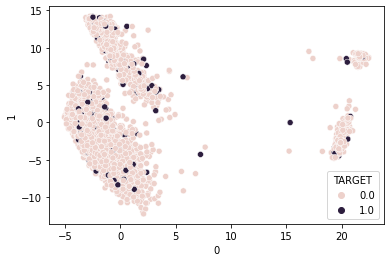

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_light)
X_pca = pca.transform(X_light)
pca_result = pd.concat([pd.DataFrame(X_pca),y],axis=1)
sns.scatterplot(pca_result[0],pca_result[1],hue=pca_result.TARGET)

In [32]:
#np.argsort(np.abs(pca.components_[0]))[::-1]

In [33]:
#np.argmax(X_light[479,:])

In [34]:
#pca.explained_variance_

# modèles de prédiction


In [35]:

lr = LogisticRegression()
gb = GaussianNB()
svc = LinearSVC()
dtc = DecisionTreeClassifier()

In [36]:
#cross_val_score(gb,X_train,y_train,cv=5).mean()


In [37]:
#cross_val_score(gb,X_train_l,y_train_l,cv=5).mean()

In [38]:
# résultats gb:
# drop nan à 50% de remplissage + input nan valeur median --> cv =0.536 acc.
# drop nan 50% + input nan valeur median + drop colonnes corrélées à 95% --> 0.517 acc.
#drop nan 50% + inpute nan mean value + sans drop colonnes corrélées/avec drop --> 0.548 acc./0.5219
#drop nan 50% + inpute nan mean value + sans drop colonnes corrélées/avec drop + scaling via robust scaler -->0.5315/0.539
#drop nan 50% + inpute nan mean value + sans drop colonnes corrélées/avec drop +imputation sur outliers + scaling via robust scaler -->

In [39]:
#gb_pred_l = gb.fit(X_train_l,y_train_l).predict(X_test_l)
#from sklearn.metrics import confusion_matrix
#display(pd.DataFrame(confusion_matrix(y_test_l,gb_pred_l)))
#fpr, tpr, thresholds = metrics.roc_curve(y_test_l, gb_pred_l)
#display(metrics.auc(fpr, tpr))

In [40]:
#svc_pred_l = svc.fit(X_train_l,y_train_l).predict(X_test_l)
#
#pd.DataFrame(confusion_matrix(y_test_l,svc_pred_l))
#fpr, tpr, thresholds = metrics.roc_curve(y_test_l, svc_pred_l)
#display(metrics.auc(fpr, tpr))

In [41]:
#lr_pred_l = lr.fit(X_train,y_train).predict(X_test)
#from sklearn.metrics import confusion_matrix
#pd.DataFrame(confusion_matrix(y_test_l,lr_pred_l))
#fpr, tpr, thresholds = metrics.roc_curve(y_test_l, lr_pred_l)
#display(metrics.auc(fpr, tpr))

In [42]:
#dtc_pred_l = dtc.fit(X_train_l,y_train_l).predict(X_test_l)
#pd.DataFrame(confusion_matrix(y_test_l,dtc_pred_l))
#fpr, tpr, thresholds = metrics.roc_curve(y_test_l, dtc_pred_l)
#display(metrics.auc(fpr, tpr))

In [43]:
#suppresion des cols corrélés : essayer imputation mean/median avant corr
# standard scaler sur les df
# detection d'outlier? --> voir avec robust scaler
# quels axes d'amélio sur la lr

# Optimisation de regression logistique via Optuna



In [44]:
!pip install optuna
import optuna

In [45]:
def objective(trial):    
    penalty = trial.suggest_categorical('Penalty',['none','l2'])
    C = trial.suggest_float('C',1,100,step =10 )
    solver = trial.suggest_categorical('solver',['lbfgs'])
    #l1_ratio = trial.suggest_float('l1_ratio',0,1,step =0.1)
    return cross_val_score(
        lr, X_train_l,y_train_l, cv=5).mean()

In [46]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)

#trial = study.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

# Optimisation tree-based models


In [47]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
cross_val_score(clf,X_train_l,y_train_l)

array([0.89316827, 0.8972854 , 0.89636831, 0.89471753, 0.89719369])

In [48]:
y_pred_l = clf.fit(X_train_l,y_train_l).predict(X_test_l)
pd.DataFrame(confusion_matrix(y_test_l,y_pred_l))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


,0,1
0,6033,747
1,552,6299


In [49]:
from sklearn import tree

In [50]:

def objective(trial):    
    criterion = trial.suggest_categorical('criterion',['gini'])
    max_depth = trial.suggest_float('max_depth',2,10,step =1)
    min_samples_split = trial.suggest_float('min_samples_split',1,41,step =10)
    min_samples_leaf = trial.suggest_float('min_samples_leaf',1,21,step =10)
    #l1_ratio = trial.suggest_float('l1_ratio',0,1,step =0.1)
    return cross_val_score(
        clf, X_train_l,y_train_l, cv=2,scoring='precision').mean()

In [51]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)

#trial = study.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [52]:
best_tree = DecisionTreeClassifier(criterion ='gini',max_depth =7,min_samples_split =10,min_samples_leaf=11)

In [53]:
bt1 = best_tree.fit(X_train_l,y_train_l)


In [54]:
cross_val_score(bt1,X_train_l,y_train_l,scoring='precision',cv=2)

array([0.8224292 , 0.80556348])

In [55]:
feat = best_tree.feature_importances_

In [56]:
def feat_importance(features,cols):
  feat_indexes =np.flatnonzero(features)
  feat_values = features[feat_indexes]
  feat_names = cols[feat_indexes]

  feat_indexes = pd.Series(feat_indexes,name ='feat_indexes')#.reset_index(drop=True)
  feat_values = pd.Series(feat_values,name ='feat_values')#.reset_index(drop=True)
  feat_names = pd.Series(feat_names,name = 'feat_names')#.reset_index(drop=True)

  features_df = pd.concat([feat_names,feat_indexes,feat_values],axis =1)
  features_df.sort_values(by=['feat_values'],ascending =False,inplace =True)
  plt.figure(figsize=(8,8))
  if len(features_df)>20:
    features_df_plot = features_df.iloc[0:20,:].copy()
  else:
    features_df_plot = features_df.copy()

  sns.barplot(data = features_df_plot,x = 'feat_values',y='feat_names')
  return(features_df.feat_names)

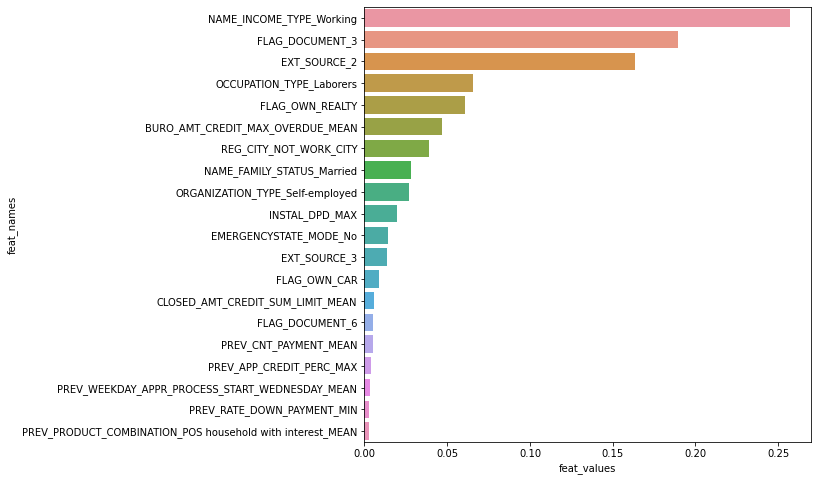

In [57]:
#cross_val_score(best_tree,X_train_l,y_train_l,cv=5,scoring ='precision')
#cross_val_score(best_tree,X_train_l,y_train_l,cv=5,scoring ='accuracy')
ft_names=feat_importance(bt1.feature_importances_,X_train_l.columns)

In [58]:
#df_corr = pd.concat([train_df['CODE_GENDER'],train_df['NAME_INCOME_TYPE_Working']],axis =1)

In [59]:
df_corr2 = train_df[ft_names]

In [60]:
#len(train_df[train_df['CODE_GENDER']==0])

In [61]:
#len(train_df[train_df['CODE_GENDER']==1])

In [62]:
#df_corr.corr()

In [63]:
cross_val_score(best_tree,X_train,y_train,cv=5,scoring ='precision')
cross_val_score(best_tree,X_train,y_train,cv=5,scoring ='accuracy')
#feat_importance(bt2.feature_importances_,X_train.columns)

array([0.86844897, 0.83342895, 0.89464082, 0.8643111 , 0.89348066])

array([0.81843191, 0.8197909 , 0.81740646, 0.8197909 , 0.8265774 ])

In [64]:
X_df = pd.DataFrame(X_train,columns = X_col)
X_df_test = pd.DataFrame(X_test,columns = X_col)

In [65]:
#X_df.drop(columns = 'CODE_GENDER',inplace = True)

In [66]:
bt3 = best_tree.fit(X_df,y_train)

array([0.86844897, 0.83342895, 0.89443684, 0.86467266, 0.8935042 ])

array([0.81843191, 0.81988261, 0.81731475, 0.8197909 , 0.8265774 ])

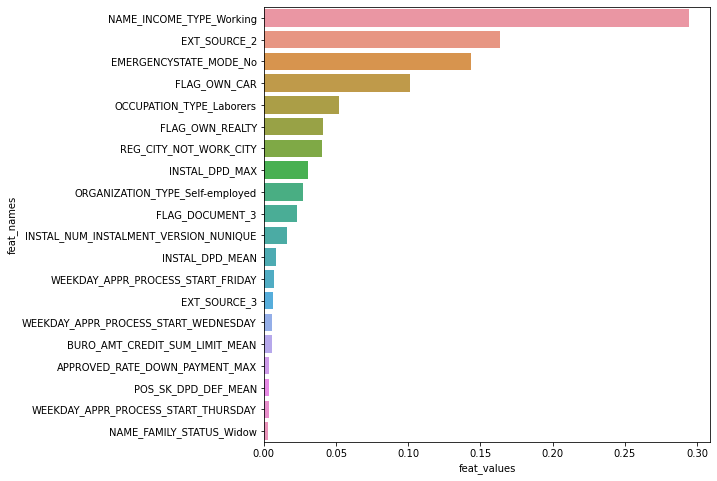

In [67]:
cross_val_score(best_tree,X_df,y_train,cv=5,scoring ='precision')
cross_val_score(best_tree,X_df,y_train,cv=5,scoring ='accuracy')
ft_name = feat_importance(bt3.feature_importances_,X_df.columns)

In [68]:
# travail 09/03
# travailler class-weight sur le classifier pour minimiser les fp
# commencer à préparer les slides
# intégrations dans le dashboard

In [69]:
best_tree = DecisionTreeClassifier(criterion ='gini',max_depth =7,min_samples_split =10,min_samples_leaf=11)
best_tree.fit(X_train,y_train)
y_pred = best_tree.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
pd.DataFrame(confusion_matrix(y_test,y_pred))
display(metrics.auc(fpr, tpr))

DecisionTreeClassifier(max_depth=7, min_samples_leaf=11, min_samples_split=10)

,0,1
0,6378,439
1,1952,4862


0.8245665683509592

In [70]:
dtc_weight = DecisionTreeClassifier(criterion ='gini',max_depth =7,min_samples_split =10,min_samples_leaf=11,class_weight ={0:1,1:5})
cross_val_score(dtc_weight,X_train,y_train,cv=5,scoring ='precision')
cross_val_score(dtc_weight,X_train,y_train,cv=5,scoring ='accuracy')


array([0.63406712, 0.62654615, 0.64895589, 0.63629764, 0.63562704])

array([0.7043558 , 0.69515774, 0.72157007, 0.70680484, 0.70561262])

In [71]:
dtc_weight.fit(X_train,y_train)
y_pred_w = dtc_weight.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_w)
pd.DataFrame(confusion_matrix(y_test,y_pred_w))
display(metrics.auc(fpr, tpr))

DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=7,
                       min_samples_leaf=11, min_samples_split=10)

,0,1
0,3120,3697
1,256,6558


0.710054810831138

In [72]:
y_prob_w = dtc_weight.predict_proba(X_test)

In [73]:
y_test_serie = pd.Series(y_test).drop(columns='index')

In [74]:
len(y_test)

13631

In [75]:
y_test_serie.reset_index(drop=True,inplace =True)

In [76]:
y_prob_w

array([[0.29339853, 0.70660147],
       [0.8189415 , 0.1810585 ],
       [0.08000214, 0.91999786],
       ...,
       [0.08000214, 0.91999786],
       [0.28115016, 0.71884984],
       [0.44690265, 0.55309735]])

In [77]:
y_prob_w = pd.DataFrame(y_prob_w).reset_index(drop = True)

In [78]:
np.shape(y_prob_w)

(13631, 2)

In [79]:
y_pred_w= pd.Series(y_pred_w)

In [80]:
y_pred_w

0        1.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
13626    1.0
13627    0.0
13628    1.0
13629    1.0
13630    1.0
Length: 13631, dtype: float64

In [81]:
df_prob = pd.concat([y_prob_w,y_test_serie,y_pred_w],axis =1,ignore_index=True)
df_prob.columns = ['prob_0','prob_1','y_test','y_pred']

In [82]:
df_prob.reset_index(inplace = True)

In [83]:
df_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13631 entries, 0 to 13630
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   13631 non-null  int64  
 1   prob_0  13631 non-null  float64
 2   prob_1  13631 non-null  float64
 3   y_test  13631 non-null  float64
 4   y_pred  13631 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 532.6 KB


In [84]:
df_prob

,index,prob_0,prob_1,y_test,y_pred
0,0,0.293399,0.706601,0.0,1.0
1,1,0.818942,0.181058,0.0,0.0
2,2,0.080002,0.919998,1.0,1.0
3,3,0.256020,0.743980,1.0,1.0
4,4,0.080002,0.919998,1.0,1.0
...,...,...,...,...,...
13626,13626,0.281150,0.718850,0.0,1.0
13627,13627,0.727273,0.272727,0.0,0.0
13628,13628,0.080002,0.919998,1.0,1.0
13629,13629,0.281150,0.718850,1.0,1.0


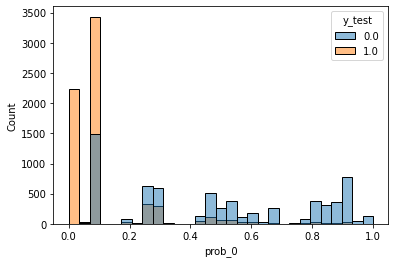

In [85]:
sns.histplot(data = df_prob,x ='prob_0',hue ='y_test')

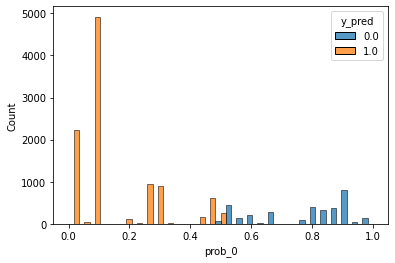

In [86]:
sns.histplot(data = df_prob,x ='prob_0',hue ='y_pred',multiple ='dodge')

In [87]:
df_prob.y_pred.value_counts()

1.0    10255
0.0     3376
Name: y_pred, dtype: int64

In [88]:
thresh = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
y_thresh = np.zeros([len(y_test),1])

for value in thresh:
  for i in range(len(y_test)):
      if df_prob.prob_0[i] > value:# and df_prob.y_test[i] <1:
        y_thresh[i] =0
      else :
        y_thresh[i] = 1
  pd.DataFrame(confusion_matrix(y_test,y_thresh))


,0,1
0,5312,1505
1,1124,5690


,0,1
0,5294,1523
1,1115,5699


,0,1
0,4003,2814
1,461,6353


,0,1
0,3982,2835
1,455,6359


,0,1
0,3120,3697
1,256,6558


,0,1
0,2561,4256
1,150,6664


,0,1
0,2105,4712
1,105,6709


,0,1
0,1922,4895
1,88,6726


,0,1
0,947,5870
1,29,6785


In [89]:
y_test.value_counts()

0.0    6817
1.0    6814
Name: TARGET, dtype: int64

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
rfc = RandomForestClassifier()

In [92]:
#cross_val_score(rfc,X_df,y_train,cv=5,scoring ='precision')
#cross_val_score(rfc,X_df,y_train,cv=5,scoring ='accuracy')


array([0.99378761, 0.99513335, 0.99438202, 0.99590004, 0.9960884 ])

array([0.96827144, 0.96670946, 0.96771827, 0.96643434, 0.96404989])

In [93]:
rfc.fit(X_df,y_train)

RandomForestClassifier()

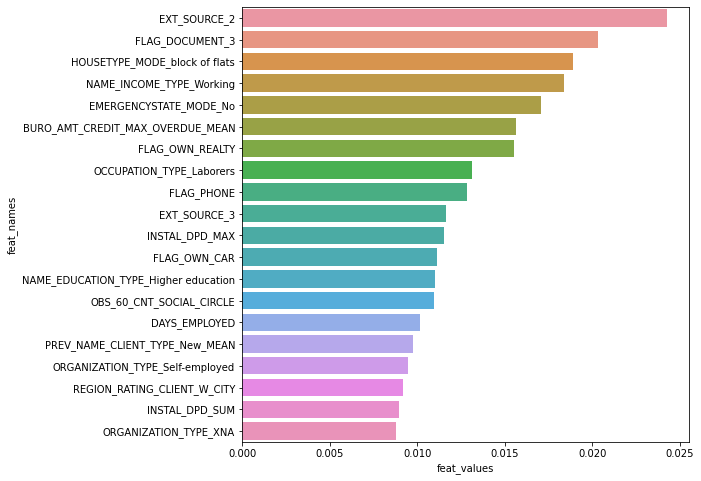

In [94]:
 ft_name_rfc = feat_importance(rfc.feature_importances_,X_df.columns)

In [95]:
ft_name_rfc

23                                          EXT_SOURCE_2
37                                       FLAG_DOCUMENT_3
82                         HOUSETYPE_MODE_block of flats
53                              NAME_INCOME_TYPE_Working
85                                EMERGENCYSTATE_MODE_No
                             ...                        
288              PREV_NAME_GOODS_CATEGORY_Insurance_MEAN
232               PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN
239    PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name th...
282           PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN
310                    PREV_CHANNEL_TYPE_Car dealer_MEAN
Name: feat_names, Length: 424, dtype: object

In [96]:
y_pred_rfc = rfc.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rfc)
pd.DataFrame(confusion_matrix(y_test,y_pred_rfc))
display(metrics.auc(fpr, tpr))

,0,1
0,6794,23
1,418,6396


0.9676408953444701

In [97]:
y_prob_rfc= rfc.predict_proba(X_test)
y_prob_rfc=pd.DataFrame(y_prob_rfc).reset_index(drop=True)
y_pred_rfc = pd.Series(y_pred_rfc).reset_index(drop = True)
df_prob = pd.concat([y_prob_rfc,y_test_serie,y_pred_rfc],axis =1,ignore_index=True)
df_prob.columns = ['prob_0','prob_1','y_test','y_pred']
thresh = [0.1,0.2,0.3,0.4,0.5]
y_thresh = np.zeros([len(y_test),1])

for value in thresh:
  for i in range(len(y_test)):
      if df_prob.prob_1[i] > value:# and df_prob.y_test[i] <1:
        y_thresh[i] =1
      else :
        y_thresh[i] = 0
  pd.DataFrame(confusion_matrix(y_test,y_thresh))

,0,1
0,1849,4968
1,4,6810


,0,1
0,4753,2064
1,24,6790


,0,1
0,6203,614
1,110,6704


,0,1
0,6700,117
1,258,6556


,0,1
0,6794,23
1,418,6396


In [98]:
ft_keep = list(ft_name_rfc[0:10])

In [99]:
ft_keep

['EXT_SOURCE_2',
 'FLAG_DOCUMENT_3',
 'HOUSETYPE_MODE_block of flats',
 'NAME_INCOME_TYPE_Working',
 'EMERGENCYSTATE_MODE_No',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'FLAG_OWN_REALTY',
 'OCCUPATION_TYPE_Laborers',
 'FLAG_PHONE',
 'EXT_SOURCE_3']

In [100]:
df_red = X_df[list(ft_keep)]

In [101]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54521 entries, 0 to 54520
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   EXT_SOURCE_2                      54521 non-null  float64
 1   FLAG_DOCUMENT_3                   54521 non-null  float64
 2   HOUSETYPE_MODE_block of flats     54521 non-null  float64
 3   NAME_INCOME_TYPE_Working          54521 non-null  float64
 4   EMERGENCYSTATE_MODE_No            54521 non-null  float64
 5   BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  54521 non-null  float64
 6   FLAG_OWN_REALTY                   54521 non-null  float64
 7   OCCUPATION_TYPE_Laborers          54521 non-null  float64
 8   FLAG_PHONE                        54521 non-null  float64
 9   EXT_SOURCE_3                      54521 non-null  float64
dtypes: float64(10)
memory usage: 4.2 MB


In [102]:
rfc_red = RandomForestClassifier()

In [103]:
rfc_red.fit(df_red,y_train)

RandomForestClassifier()

In [104]:
y_pred_rfc_red = rfc.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rfc_red)
pd.DataFrame(confusion_matrix(y_test,y_pred_rfc_red))
display(metrics.auc(fpr, tpr))

,0,1
0,6794,23
1,418,6396


0.9676408953444701

In [105]:
np.shape(test_df)

(48744, 559)

In [106]:
np.shape(X_train)

(54521, 558)

In [107]:
test_df.drop(columns = 'TARGET',inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [108]:
y_pred_test_df = pd.Series(rfc.predict(test_df),name ='prediction').reset_index(drop=True)
y_pred_test_prob = pd.DataFrame(rfc.predict_proba(test_df),columns =['prob_0','prob_1']).reset_index(drop =True)

In [129]:
df_feat = test_df[list(ft_keep)].reset_index(drop=True)
test_id.reset_index(drop=True,inplace =True)
df_results = pd.concat([test_id,df_feat,y_pred_test_df,y_pred_test_prob],axis =1)

In [132]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SK_ID_CURR                        48744 non-null  int64  
 1   EXT_SOURCE_2                      48744 non-null  float64
 2   FLAG_DOCUMENT_3                   48744 non-null  int64  
 3   HOUSETYPE_MODE_block of flats     48744 non-null  int64  
 4   NAME_INCOME_TYPE_Working          48744 non-null  int64  
 5   EMERGENCYSTATE_MODE_No            48744 non-null  int64  
 6   BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  48744 non-null  float64
 7   FLAG_OWN_REALTY                   48744 non-null  int64  
 8   OCCUPATION_TYPE_Laborers          48744 non-null  int64  
 9   FLAG_PHONE                        48744 non-null  int64  
 10  EXT_SOURCE_3                      48744 non-null  float64
 11  prediction                        48744 non-null  float64
 12  prob

In [133]:
df_results.to_csv(path_or_buf=path + 'rfc_results.csv')

In [128]:
len(test_id)

48744

In [125]:
test_id.isna().sum()

0

In [131]:
df_results['SK_ID_CURR'].isna().sum()

0